In [80]:
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Hashable
from admire.preprocessing import mapping_functions
from admire.preprocessing.data_preparation import DataPreparation

data_dir = 'data/'
# load csv
df_raw = pd.read_csv(f'{data_dir}/jobs_flattened_cleaned_1.csv')

# Drop where nodes is NaN
df_raw = df_raw.dropna(subset=['nodes', 'steps-tres-requested-min-cpu-node']).reset_index(drop=True)

# Override NaN constraints values with 'no-constraints'
df_raw['constraints'] = df_raw['constraints'].fillna('no-constraints')

# Drop designated columsn
to_drop = ['reservation', 'qos', 'working_directory', 'user', 'steps-nodes-range']
# all with steps-tres ... -node
to_drop += [col for col in df_raw.columns if 'steps-tres' in col and '-node' in col]
# all starting with time- or wckey
to_drop += [col for col in df_raw.columns if col.startswith('time-') or col.startswith('wckey-')]
print(f'Drop columns: {to_drop}')
df_raw = df_raw.drop(columns=to_drop)

# Combine flags into one column
df_raw['flags'] = df_raw['flags'].apply(lambda x: '-'.join(x.split(',')))

# Drop columns which have only ONE unique value
df_raw = df_raw.loc[:, df_raw.nunique() != 1]

# Drop NaN columns
df_raw = df_raw.dropna(axis=1, how='all')

# Change all ambiguous columns to string type
ambigous = df_raw.select_dtypes(include=['object']).columns
df_raw[ambigous] = df_raw[ambigous].astype(str)


df_raw.info()

Drop columns: ['reservation', 'qos', 'working_directory', 'user', 'steps-nodes-range', 'steps-tres-requested-max-cpu-node', 'steps-tres-requested-max-mem-node', 'steps-tres-requested-max-energy-node', 'steps-tres-requested-max-fs-node', 'steps-tres-requested-max-vmem-node', 'steps-tres-requested-max-pages-node', 'steps-tres-requested-min-cpu-node', 'steps-tres-requested-min-mem-node', 'steps-tres-requested-min-energy-node', 'steps-tres-requested-min-fs-node', 'steps-tres-requested-min-vmem-node', 'steps-tres-requested-min-pages-node', 'steps-tres-consumed-max-energy-node', 'steps-tres-consumed-max-fs-node', 'steps-tres-consumed-min-energy-node', 'steps-tres-consumed-min-fs-node', 'steps-tres-allocated-node', 'time-elapsed', 'time-eligible', 'time-end', 'time-start', 'time-submission', 'time-suspended', 'time-system-seconds', 'time-system-microseconds', 'time-limit', 'time-total-seconds', 'time-total-microseconds', 'time-user-seconds', 'time-user-microseconds', 'wckey-wckey', 'wckey-fla

C:\Users\232_DETI\AppData\Local\Temp\ipykernel_16540\2460921380.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(f'{data_dir}/jobs_flattened_cleaned_1.csv')


Text(0.5, 1.0, 'Correlation plot (only for features with absolute correlation > 0.4)')

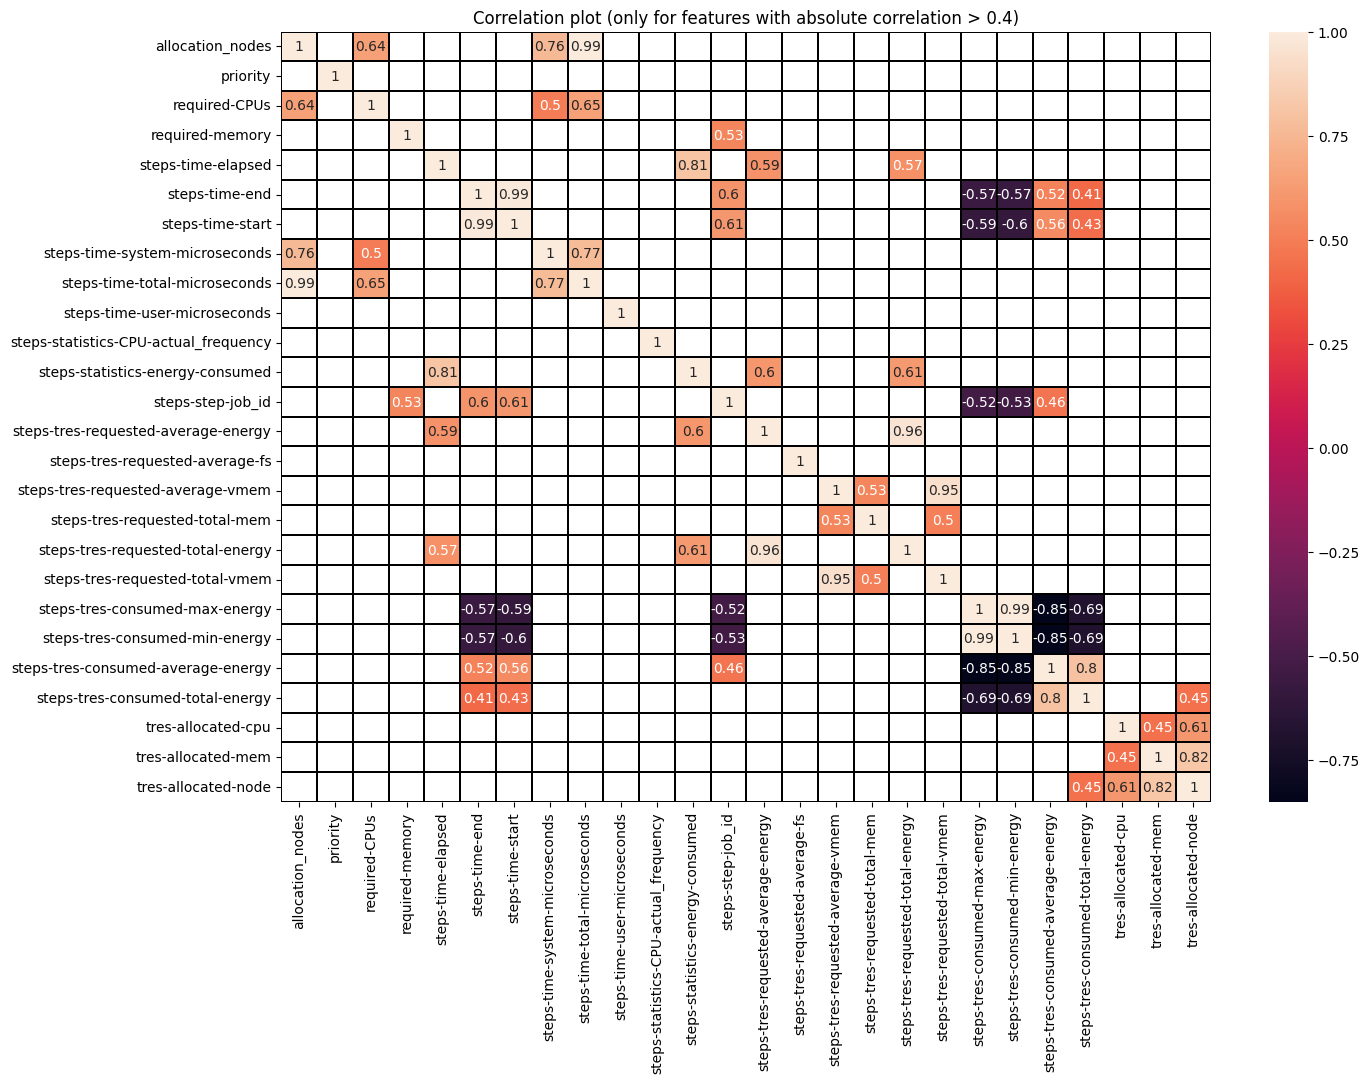

In [123]:
plt.figure(figsize=(15,10))
redundant_columns = [
    'steps-tasks-count', 
    'steps-nodes-count', 
    
    'steps-tres-requested-max-mem', 
    'steps-tres-requested-min-mem', 
    'steps-tres-requested-average-mem', # only 1 record different than -total-mem
    
    'steps-tres-requested-min-energy', 
    'steps-tres-requested-max-energy',
    
    'steps-tres-requested-max-fs',
    'steps-tres-requested-min-fs',
    'steps-tres-requested-total-fs',
    
    'steps-tres-requested-min-vmem',
    'steps-tres-requested-max-vmem',
    
    'steps-tres-allocated-cpu',
    'steps-tres-allocated-mem',
    'steps-tres-allocated-billing',
    'steps-tres-consumed-total-fs',
    
    'tres-requested-billing',
    'tres-requested-cpu',
    'tres-requested-mem',
    'tres-requested-node',
    ]

threshold = 0.4
corr = df_raw.select_dtypes(exclude=['object']).drop(columns=redundant_columns).corr().round(5)
sns.heatmap(corr[corr.abs() > threshold], annot=True, linewidths=0.1, linecolor='black')
plt.title(f'Correlation plot (only for features with absolute correlation > {threshold})')

In [121]:
df_raw.to_csv(f'data/jobs_step_1_final.csv', index=False)

In [105]:
(df_raw['steps-tres-consumed-min-energy'] == df_raw['steps-tres-consumed-max-energy']).value_counts()

True     11444
False      158
dtype: int64

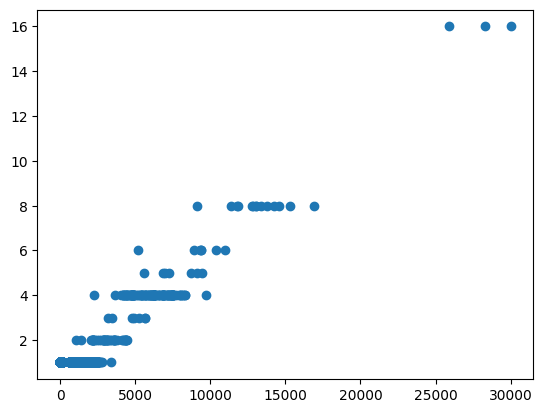

In [119]:
plt.scatter(df_raw['steps-time-system-microseconds'], df_raw['allocation_nodes'])